In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

from bruit_schiolerSilverman import schioler
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite_inhomogene
from bruit_schiolerSilverman import affichage_illustratif_schioler

from bruit_schiolerSilverman import decoupageEnDeuxSousEnsembles
from bruit_schiolerSilverman import affichage_ensembles

from learning_schiolerSilverman import affichage_reseau_et_donnees
from learning_schiolerSilverman import apprentissage
from learning_schiolerSilverman import affichage_performances_et_donnees
from learning_schiolerSilverman import affiche_rms

# Régression par Perceptron Multicouches (Notions)
***

Le but de ce TP est de mettre en oeuvre une méthodologie constructive pour déterminer une fonction de régression à l’aide de perceptrons multicouches (PMC). 
Ce TP comporte 2 Parties :
- Un PMC réalisant une régression à partir de données brutes simulées pour approximer l’espérance.
- Une approximation de la variance de données brutes également effectuée par une régression à l’aide d’un PMC.

Ce TP permettra de faire ressortir quelques notions associées à l'apprentissage de la régression. 
Nous nous limitons ici à l'apprentissage de données simulées dans deux cas simples.
Nous considérons, ici, des fonctions (connues et de complexité limitée) caractérisées par une entrée et une sortie qui seront apprises sur un intervalle réduit.
**L'objectif est d'appréhender les notions associées à l'apprentissage pour être ensuite apte à traiter des problèmes plus réalistes.** Cela va bien au-delà d'apprendre les deux fonction étudiées ou d'afficher de bonnes performances d'apprentissage (pour ces deux fonctions). 


## Les données simulées "schioler"

Dans cette partie nous présentons le jeu de données simulées. 
Pour rappel, il est généré à partir d'une fonction à une entrée et une sortie qui correspond à la fonction théorique à retrouver. On y ajoute un bruit pour générer le jeu de données. On pourra ainsi, a volo, génerer des jeux de données simulées constituées d'une entrée et de la sortie (bruitée) correspondante.

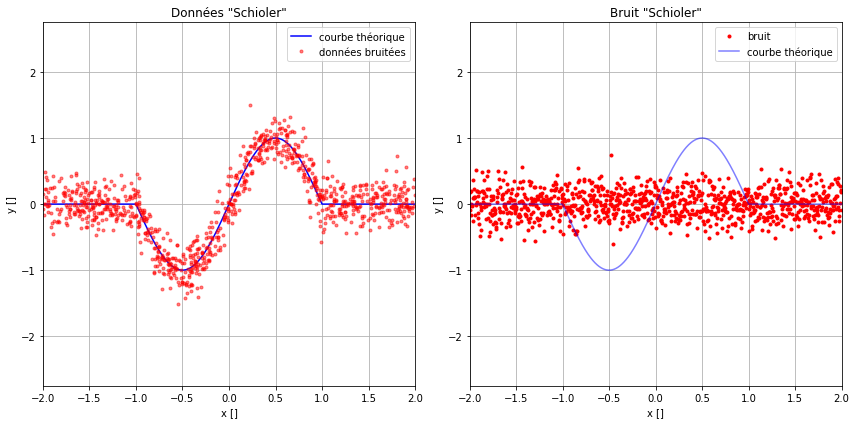

In [2]:
plt.figure(figsize=(12,6))
affichage_illustratif_schioler()

In [3]:
#np.random.seed(0);    # (Re)positionnement du random (ou pas)

### Simulation d'un jeu de données

On a une fonction $f$ dont on ne connait que $n$ valeurs bruitées prises aléatoirement sur un intervalle donné $[x_\text{min} ; x_\text{max}]$. 
Pour chacun des $x_i$, tirées aléatoirement, on mesure une valeur $y_i$ somme d'un bruit et de la valeur prise par la fonction en $x_i$.  
On a ainsi :
$$ y_i = f(x_i) + \varepsilon_i $$

A l'aide d'un perceptron multicouche, on va déterminer un estimateur $f^*$ de la une fonction $f$.  
Cet estimateur sera obtenu à partir des $n$ mesures : $(x_i,y_i)$.

Comme tout estimateur, il y aura un compromis à faire entre biais et variance.  
Pour se prémunir du surapprentissage, on va séparer notre ensemble en trois partie :
 - ensemble d'apprentissage, 
 - ensemble de validation, et 
 - ensemble de test.

In [4]:
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
r_l=.5 # proportion de l'ensemble d'apprentissage 

# generation du jeu de donnees aleatoires
xi,yi = jeuDeDonnees_schioler_bruite(nombreDeDonnees_appVal,sigma=.2)

# decoupage en deux ensembles d'apprentissage et de validation
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)
n_app = np.size(x_app,0)
n_val = np.size(x_val,0)

On a, par ailleurs, un **ensemble de test** qui ne sera utilisé qu'une fois l'apprentissage terminé, i.e. une fois l'architecture retenue et les poids déterminés. 
Cet ensemble nous permettra  de savoir comment notre perceptron multicouche se comportera en généralisation i.e. avec de nouvelles valeurs de $x_i$ (dans la même gamme de valeurs) non apprises.

In [5]:
# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_schioler_bruite(nombreDeDonnees_test,sigma=.2)
n_test = np.size(x_test,0)

quelques lignes de commandes fonctionnelles

In [6]:
# mise en forme pour MLPRegressor 
x_app = np.reshape(x_app, [n_app, 1])
x_val = np.reshape(x_val, [n_val, 1])
x_test = np.reshape(x_test, [n_test, 1])    

#### Affichage du jeu de données

Etant dans un cas simple, nous pouvons afficher le jeu de données ainsi que la fonction recherchée (qui reste simple).  
Dans un cas réel, le nombre de dimension ne nous le permettrait pas.

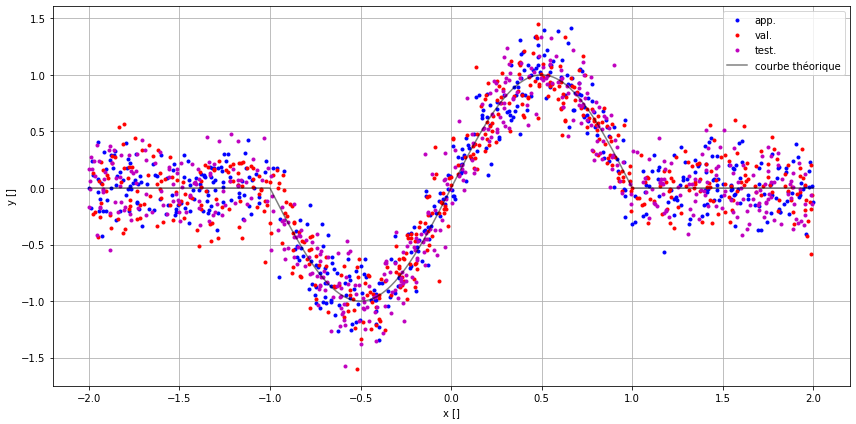

In [7]:
# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-2,2,n_maillage).reshape(n_maillage,1) 

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,schioler)

## Apprentissage i.e. estimation d'une fonction par MLP

##### Quelques possibilités offertes par sklearn

On va ici présenté quelques unes des possibilités offertes par la bibliothèque [scikit-learn](https://scikit-learn.org/stable/documentation.html).  
On s'intéresse, dans un premier temps, à la classe [mlpRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).  
(Ne pas hésiter à suivre le lien pour consulter la documentation. 
Regarder en particulier le coût utilisé lors de l'apprentissage.)

Cette classe ne permet pas de séparer explicitement les ensembles d'apprentissage et de validation.  
On n'a pas directement accès à l'évolution des poids découlant d'un apprentissage.

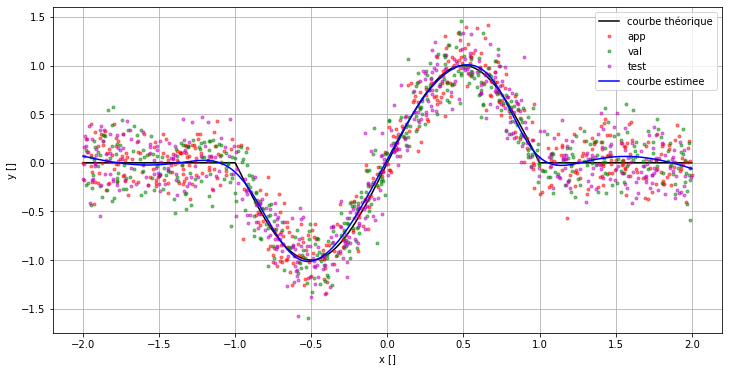

In [34]:
rgrsr = MLPRegressor(activation='tanh', 
                     hidden_layer_sizes = (9),
                     early_stopping=True,
                     validation_fraction=r_l, 
                     max_iter = 500000,
                     alpha=0.01, 
                     solver='lbfgs', 
                     learning_rate = 'adaptive')

rgrsr = rgrsr.fit(np.vstack((x_app,x_val)), np.hstack((y_app,y_val)))

#x_appVal = np.reshape(x_appVal, [n_appVal, 1]) # [160, ] -> [160, 1]
#y_appVal = np.reshape(y_appVal, [n_appVal, 1]) # [160, ] -> [160, 1]
#a = rgrsr.fit(x_appVal, y_appVal.ravel())

plt.figure(figsize=(12,6))
affichage_reseau_et_donnees(rgrsr,x_maillage,x_app,y_app,x_val,y_val,schioler,x_test=x_test,y_test=y_test) ;

In [35]:
def forward(x,rgrsr):
    inp =  np.array(x)
    tmp = inp
    tmp = rgrsr.coefs_[0].T.dot(tmp.T)  
    tmp = tmp + rgrsr.intercepts_[0].reshape(tmp.shape)
    tmp = np.tanh(tmp)
    tmp = rgrsr.coefs_[1].T.dot(tmp) 
    tmp = tmp +rgrsr.intercepts_[1].reshape(tmp.shape)
    return tmp

forward(-0.5,rgrsr)

array([[-1.01184526]])

In [36]:
rgrsr.predict(np.vstack(([-0.5])))

array([-1.01184526])

In [37]:
rgrsr.intercepts_

[array([-0.47892937,  0.82063535,  0.06257275,  2.50002746,  1.61225269,
         1.16315774,  1.30893587,  3.52188961, -0.66117664]),
 array([-0.88671314])]

In [38]:
rgrsr.coefs_

[array([[ 1.28224899,  1.50389324,  0.39680077,  3.15857694,  1.81046195,
         -2.51659625,  0.29559089, -4.27013499,  0.26220902]]),
 array([[ 4.5499561 ],
        [ 0.34735497],
        [-1.93592328],
        [-1.70599194],
        [ 1.18775269],
        [ 1.38405766],
        [ 0.19361914],
        [ 1.10847404],
        [-1.74345453]])]

In [39]:
def get_internal(maillage,rgrsr):
    values=list()
    values.append(list())
    for zz in range(rgrsr.coefs_[1].shape[0]): 
        values.append(list())
    for x in maillage:
        inp =  np.array(x)
        tmp = inp
        tmp = rgrsr.coefs_[0].T.dot(tmp.T)  
        tmp = tmp + rgrsr.intercepts_[0].reshape(tmp.shape)
        tmp = np.tanh(tmp)
        for i in range(tmp.shape[0]):
            values[i].append([tmp[i]]*rgrsr.coefs_[1][i])
        #print(rgrsr.coefs_[1])
        tmp = rgrsr.coefs_[1].T.dot(tmp) 
        tmp = tmp +rgrsr.intercepts_[1].reshape(tmp.shape)
        values[-1].append(tmp)
    #print(values)
    return values

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

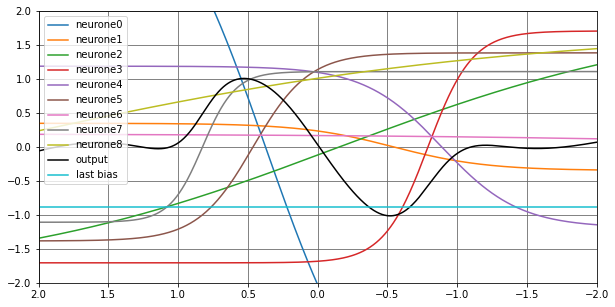

In [41]:
z = get_internal(x_maillage,rgrsr)
plt.xlim(right=-2)  # adjust the right leaving left unchanged
plt.xlim(left=2)
plt.ylim(bottom=-2)  # adjust the right leaving left unchanged
plt.ylim(top=2) 
plt.grid(b=True, which='major', color='#666666', linestyle='-')
for i,var in enumerate(z[:-1]): 
    plt.plot(x_maillage, var,label="neurone"+str(i))
plt.plot(x_maillage,z[-1],'k',label="output")
plt.plot(x_maillage,rgrsr.intercepts_[1]*np.ones(len(x_maillage)),label="last bias")
sum = list()
#for i in range(len(x_maillage)):
#    sum.append(z[0][i]+z[1][i]+z[2][i])
#plt.plot(x_maillage,sum,label="sum")
plt.legend()

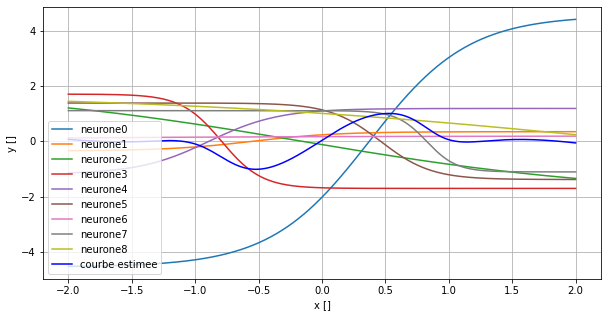

In [42]:
ax = plt.gca()
#ax.plot(x_maillage,sumz,'k-',label='courbe théorique')
#ax.plot(x_app,y_app,'r.',alpha=.5,label='app')
#ax.plot(x_val,y_val,'g.',alpha=.5,label='val')

for i,var in enumerate(z[:-1]): 
    ax.plot(x_maillage, var,label="neurone"+str(i))

# courbe estimee
ax.plot(x_maillage,rgrsr.predict(x_maillage),'b-',label='courbe estimee')
ax.grid(True)
ax.set_xlabel("x []")
ax.set_ylabel("y []")
ax.legend()

In [43]:
rgrsr.coefs_[0].T.dot(np.array(2))

array([[ 2.56449798],
       [ 3.00778648],
       [ 0.79360154],
       [ 6.31715388],
       [ 3.62092391],
       [-5.03319251],
       [ 0.59118179],
       [-8.54026997],
       [ 0.52441804]])

In [44]:
rgrsr.intercepts_[0].reshape(rgrsr.coefs_[0].shape).shape

(1, 9)

In [45]:
rgrsr.intercepts_[1]

array([-0.88671314])

In [46]:
rgrsr.predict(np.vstack(([10])))

array([-2.41707006])

Parmi les possibilités offertes par scikit-learn, il est possible de faire appel à la fonction [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html).  
(Voir [un exemple](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py) de la documentation.)

In [47]:
rgrsr = MLPRegressor(activation='tanh', 
                     hidden_layer_sizes = (3),
                     early_stopping=True,
                     validation_fraction=r_l, 
                     max_iter = 500000,
                     alpha=0.01, 
                     solver='lbfgs', 
                     learning_rate = 'adaptive',
                     verbose=True)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(rgrsr, 
                                                        np.vstack((x_app,x_val)), 
                                                        np.hstack((y_app,y_val)), 
                                                        cv=cv, 
                                                        train_sizes=train_sizes, 
                                                        scoring='neg_mean_squared_error') ;


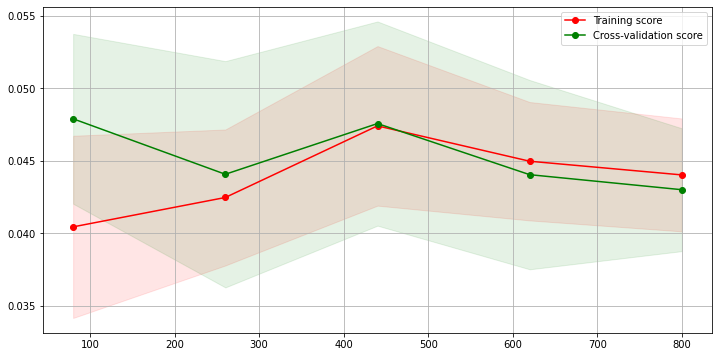

In [22]:
plt.figure(figsize=(12,6))
train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, 
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best") ; 

Bien que très utiles les deux fonctions utilisées ne permettent pas réellement d'expérimenter avec l'apprentissage.  Dans ce qui suit on cherche à appréhender explicitement les rôles joués par différents paramétrages de l'apprentissage.

### Pour s'intéresser à l'apprentissage

Ici, on va utiliser un certain nombre de fonctions fournies dans le fichier `learning_schioler.py`  : 

 - `apprentissage`, permettant un affichage détaillé des performances d'apprentissage
 - `affichage_performances_et_donnees`, affichant les performances d'apprentisage ainsi que la fonction estimées au milieu des données pour différents estimateurs
 - `affiche_rms`, donnant les coûts associés à chaque jeu de poids retenu pour différentes architectures

#### apprentissage d'un mlp

In [23]:
# Apprentissage pour un nombre de neurones en couche cachée
n_hidden = 9
# specification du modele
rgrsr = MLPRegressor(activation='tanh', hidden_layer_sizes = (n_hidden), warm_start='True',solver='lbfgs', learning_rate = 'adaptive',max_iter=1)

# apprentissage du modele
rgrsr, erreurs_app, erreurs_val, cpt_erreur_val_min = apprentissage(rgrsr,x_app, y_app,x_val, y_val,max_n_iter=500)

##### affichage des performances de l'apprentissage 

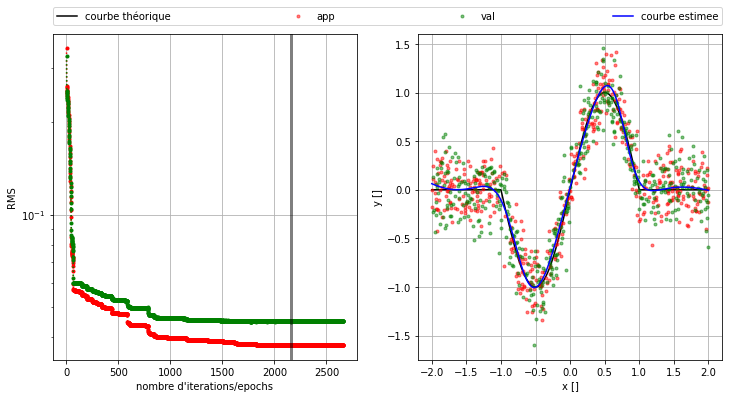

In [24]:
fig= plt.figure(figsize=(12,6))
affichage_performances_et_donnees(erreurs_app,erreurs_val,cpt_erreur_val_min,
                                  n_hidden,rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage)

In [25]:
affiche_rms(n_hidden,erreurs_app,erreurs_val,cpt_erreur_val_min)
print()

       m  err_app  err_val
       9  0.03769  0.04485



Bien qu'on ne le devrait pas, on va considérer l'ensemble de test et les performances associées.  
Cela devrait nous permettre de prendre du recul sur l'effet des paramètres d'apprentissage sur la généralisation. 

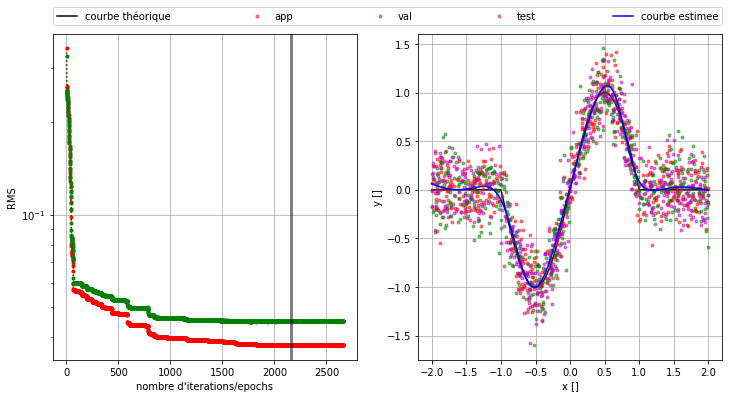

In [26]:
fig= plt.figure(figsize=(12,6))
affichage_performances_et_donnees(erreurs_app,erreurs_val,cpt_erreur_val_min,
                                  n_hidden,rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage,
                                  x_test, y_test)

In [27]:
affiche_rms(n_hidden,erreurs_app,erreurs_val,cpt_erreur_val_min,x_test=x_test,y_test=y_test,rgrsr=rgrsr)
print() 

       m  err_app  err_val      err_test
       9  0.03769  0.04485     (0.04393)



#### apprentissage de plusieurs architectures

In [28]:
# Apprentissage pour un nombre de neurones en couche cachée
liste_n_hidden = list(range(1,10,2))

# initialisation
liste_rgrsr         = list()
liste_erreurs_app = list()
liste_erreurs_val = list()
liste_cpt_erreur_val_min  = list()

# specification du modele
for i,n_hidden in enumerate(liste_n_hidden): 
    print(n_hidden)
    rgrsr = MLPRegressor(activation='tanh', hidden_layer_sizes = (n_hidden), warm_start='True',solver='lbfgs', learning_rate = 'adaptive',max_iter=1)

    # apprentissage du modele
    rgrsr, erreurs_app, erreurs_val, cpt_erreur_val_min = apprentissage(rgrsr,x_app, y_app,x_val, y_val,max_n_iter=500)
    liste_rgrsr.append(rgrsr)
    liste_erreurs_app.append(erreurs_app)
    liste_erreurs_val.append(erreurs_val)
    liste_cpt_erreur_val_min.append(cpt_erreur_val_min)

1
3
5
7
9


##### affichage des performances  d'apprentissage

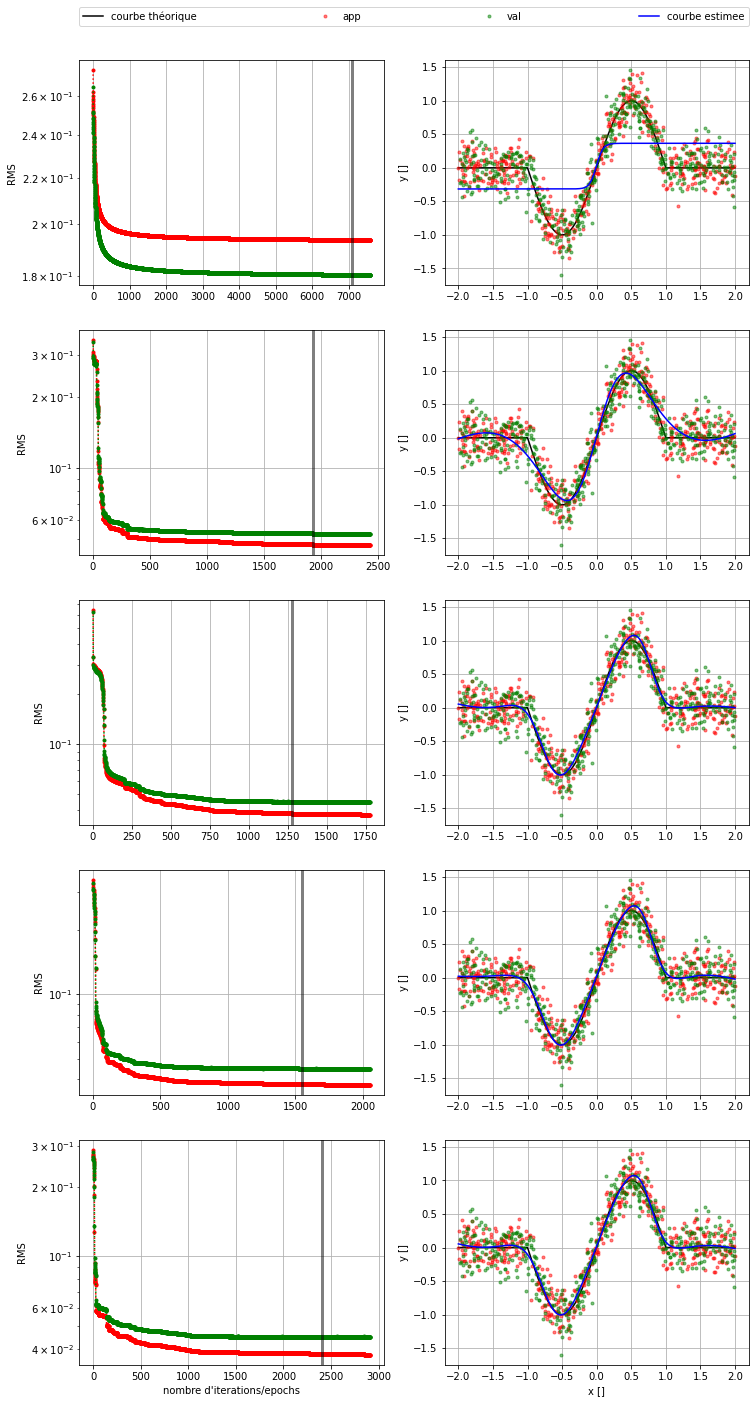

In [29]:
fig= plt.figure(figsize=(12,24))
affichage_performances_et_donnees(liste_erreurs_app,liste_erreurs_val,
                                  liste_cpt_erreur_val_min,
                                  liste_n_hidden,liste_rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage)
    

In [30]:
    affiche_rms(liste_n_hidden,liste_erreurs_app,liste_erreurs_val,liste_cpt_erreur_val_min)
    print()
    

       m  err_app  err_val
       1  0.19377  0.18039
       3  0.04721  0.05242
       5  0.03840  0.04502
       7  0.03791  0.04472
       9  0.03798  0.04478



Comme précédemment on va considérer l'ensemble de test et les performances associées.  
Là encore, bien qu'on ne le devrait pas, cela devrait nous permettre de prendre du recul sur l'effet des paramètres d'apprentissage sur la généralisation. 

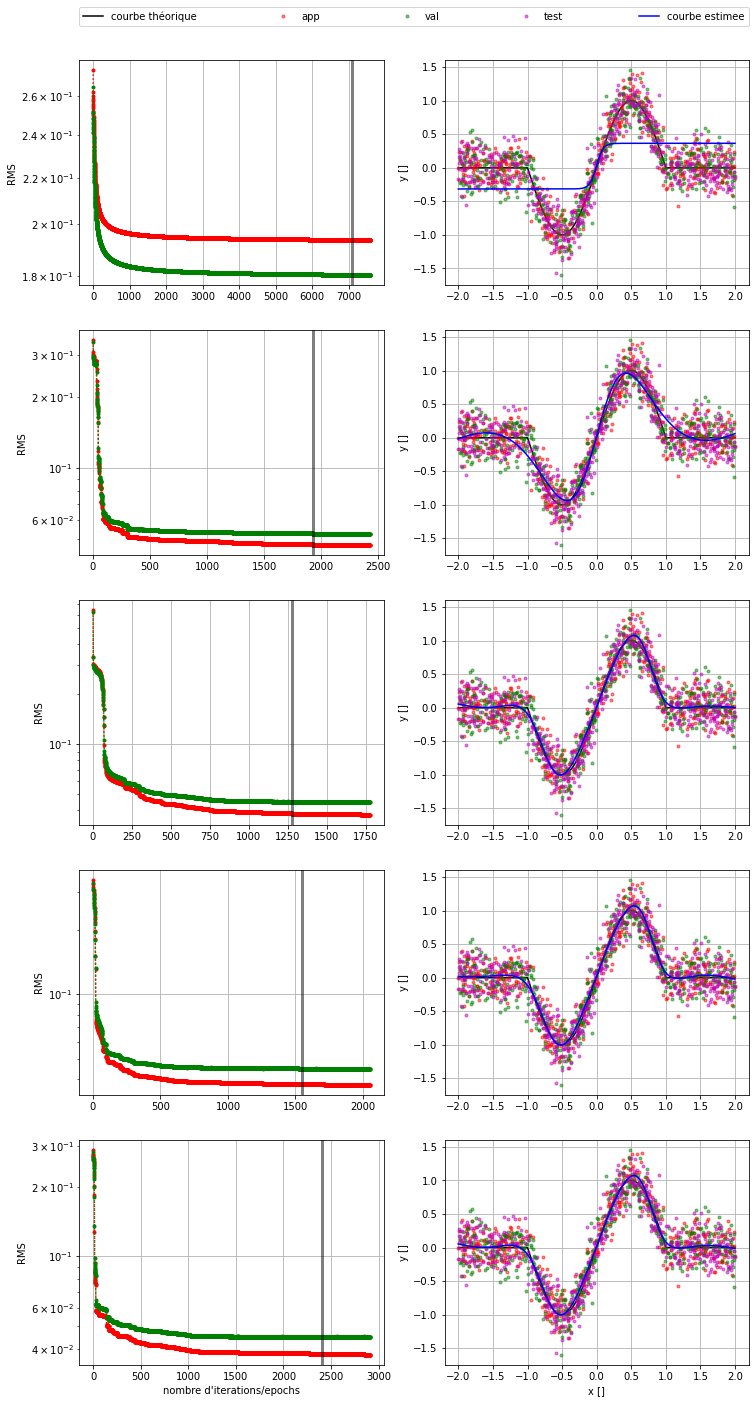

In [31]:
fig= plt.figure(figsize=(12,24))
affichage_performances_et_donnees(liste_erreurs_app,liste_erreurs_val,
                                  liste_cpt_erreur_val_min,
                                  liste_n_hidden,liste_rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage,
                                  x_test, y_test)

In [32]:
affiche_rms(liste_n_hidden,liste_erreurs_app,liste_erreurs_val,liste_cpt_erreur_val_min,x_test=x_test,y_test=y_test,rgrsr=liste_rgrsr)
print()

       m  err_app  err_val      err_test
       1  0.19377  0.18039     (0.20296)
       3  0.04721  0.05242     (0.04868)
       5  0.03840  0.04502     (0.04418)
       7  0.03791  0.04472     (0.04403)
       9  0.03798  0.04478     (0.04394)

